# Multi-label classification -- p-classification loss

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from scipy.io import arff
from scipy.optimize import minimize
from scipy.optimize import check_grad

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('src')
from evaluate import avgPrecision, avgPrecisionK, printEvaluation

In [3]:
data_dir = 'data'
yeast_ftrain = os.path.join(data_dir, 'yeast/yeast-train.arff')
yeast_ftest  = os.path.join(data_dir, 'yeast/yeast-test.arff')

In [4]:
SEED = 123456789

## Data loading

Load yeast dataset.

In [5]:
data_train, meta_train = arff.loadarff(yeast_ftrain)

In [6]:
data_test, meta_test = arff.loadarff(yeast_ftest)

In [7]:
type(data_train)

numpy.ndarray

In [8]:
#print(data_train[0])

In [9]:
len(list(data_train[0]))

117

Features

In [10]:
nFeatures = np.array(list(data_train[0])[:-14], dtype=np.float).shape[0]
print('#features:', nFeatures)

#features: 103


In [11]:
#np.array(list(data_train[0])[:-14], dtype=np.float)

Labels

In [12]:
nLabels = np.array(list(data_train[0])[-14:], dtype=np.int).shape[0]
print('#labels:', nLabels)

#labels: 14


In [13]:
#np.array(list(data_train[0])[-14:], dtype=np.int)

## Data analysis

In [14]:
print('#training examples:', len(data_train))

#training examples: 1500


In [15]:
print('#test examples:', len(data_test))

#test examples: 917


Histogram of #positive labels.

In [16]:
nPositives = [np.sum(np.array(list(data_train[ix])[-14:], dtype=np.int)) for ix in range(len(data_train))]

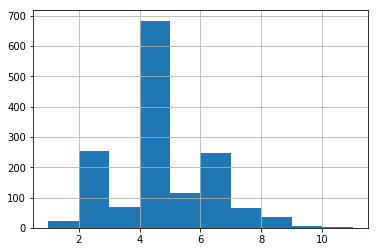

In [17]:
pd.Series(nPositives).hist(bins=10)

## Dataset creation

In [18]:
def create_dataset(data):
    """
        Create the labelled dataset for a given label index
        
        Input:
            - data: original data with features + labels
            
        Output:
            - (Feature, Label) pair (X, y)
              X comprises the features for each example
              Y comprises the labels of the corresponding example
    """

    N = len(data)
    D = nFeatures
    L = nLabels

    magic = -14

    X = np.zeros((N, D), dtype = np.float)
    Y = np.zeros((N, L), dtype = np.int)
       
    for i in range(N):
        X[i, :] = list(data[i])[:magic]
        Y[i, :] = list(data[i])[magic:]

    return X, Y

## Evaluation

The sigmoid function.

In [19]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Loss between a ground truth and a prediction.

In [20]:
def evalPred(truth, pred, lossType = 'Hamming'):
    """
        Compute loss given ground truth and prediction
        
        Input:
            - truth:    binary array of true labels
            - pred:     real-valued array of predictions
            - lossType: can be subset 0-1, Hamming, ranking, and Precision@K where K = # positive labels.
    """

    assert(len(truth) == len(pred))
    L = len(truth)
    nPos = np.sum(truth)
    
    predBin = np.array((pred > 0), dtype=np.int)
    
    if lossType == 'Subset01':
        return 1 - int(np.all(truth == predBin))
    
    elif lossType == 'Hamming':
        return np.sum(truth != predBin) / L
    
    elif lossType == 'Ranking':
        loss = 0
        for i in range(L-1):
            for j in range(i+1, L):
                if truth[i] > truth[j]:
                    if pred[i] < pred[j]: 
                        loss += 1
                    if pred[i] == pred[j]:
                        loss += 0.5
        #return loss / (nPos * (L-nPos))
        return loss
        
    elif lossType == 'Precision@K':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:nPos])if nPos > 0 else 0
    
    elif lossType == 'Precision@3':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:3])
    
    elif lossType == 'Precision@5':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:5])
    
    else:
        assert(False)

In [21]:
def avgPrecisionK(allTruths, allPreds):
    losses = []
    lossType = 'Precision@K'
    for i in range(allPreds.shape[0]):
        pred  = allPreds[i, :]
        truth = allTruths[i, :]
        losses.append(evalPred(truth, pred, lossType))
    return np.mean(losses)

In [22]:
def printEvaluation(allTruths, allPreds):
    
    N = allTruths.shape[0]
    #print(N)

    for lossType in ['Precision@K']: 
        # ['Subset01', 'Hamming', 'Ranking', 'Precision@K', 'Precision@3', 'Precision@5']:
        losses = [ ]
        for i in range(allPreds.shape[0]):
            pred  = allPreds[i, :]
            truth = allTruths[i, :]
            losses.append(evalPred(truth, pred, lossType))

        #print('%24s: %1.4f' % ('Average %s Loss' % lossType, np.mean(losses)))
        print('%s: %1.4f, %.3f' % ('Average %s' % lossType, np.mean(losses), np.std(losses) / np.sqrt(N)))
        #plt.hist(aucs, bins = 10);

## p-classification loss

Multi-label learning with p-norm push loss.

In [23]:
def obj_pnorm_push(w, X, Y, p, C):
    """
        Objective with L2 regularisation and p-classification push loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - p: constant for p-classification push loss
            - C: regularisation constant, is consistent with scikit-learn C = 1 / (N * \lambda)
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    assert(p >= 1)
    assert(C > 0)
    
    W = w.reshape(L, D)  # reshape weight matrix
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    nPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    nNegAll = L - nPosAll        # number of negative labels for each example, N by 1
    
    for k in range(nLabels):
        wk = W[k, :]
        Yk = Y[:, k]
        sPosVec = np.dot(X[Yk == 1, :], wk)      # Nk+ by 1
        sNegVec = np.dot(X[Yk == 0, :], wk)      # NK- by 1
        nPosVec = nPosAll[Yk == 1]               # Nk+ by 1
        nNegVec = nNegAll[Yk == 0]               # NK- by 1
        
        #nPosVec = np.sum(Y[Yk == 1, :], axis=1)  # Nk+ by 1
        #nNegVec = np.sum(Y[Yk == 0, :], axis=1)  # NK- by 1
        #nPosVec = np.sum(Y[Yk == 1, :], axis=1) + 0.01 # Nk+ by 1 with smoothing
        #nNegVec = np.sum(Y[Yk == 0, :], axis=1) + 0.01 # NK- by 1 with smoothing
        
        #nPosVec = np.ones_like(sPosVec) * N
        #nNegVec = np.ones_like(sNegVec) * N
        lossPos = np.divide(np.exp(-sPosVec), nPosVec)     # NK+ by 1
        lossNeg = np.divide(np.exp(p * sNegVec), nNegVec)  # NK- by 1
        
        J += np.sum(lossPos) + np.sum(lossNeg) / p
        
        GradPos = -X[Yk == 1, :] * lossPos[:, None]
        GradNeg =  X[Yk == 0, :] * lossNeg[:, None]
        
        G[k, :] = np.sum(GradPos, axis=0) + np.sum(GradNeg, axis=0)
                
    #J = 0.5 * C * np.dot(w, w) + J / N
    #G = C * W + G / N
    
    # be consistent with scikit-learn C = 1 / (N * \lambda)
    J = 0.5 * np.dot(w, w) + C * J
    G = W + C * G
    
    return (J, G.ravel())

Check gradient

In [24]:
X_train, Y_train = create_dataset(data = data_train)
X_test,  Y_test  = create_dataset(data = data_test)

In [25]:
#%%script false
#C = 1  # if C is lambda
C = 1/X_train.shape[0]
p = 1
w0 = np.random.rand(nFeatures * nLabels)
check_grad(lambda w: obj_pnorm_push(w, X_train, Y_train, p, C)[0], \
           lambda w: obj_pnorm_push(w, X_train, Y_train, p, C)[1], w0)

4.6159169246469862e-05

In [26]:
class MLC_pclassification(BaseEstimator):
    """All methods are necessary for a scikit-learn estimator"""
    
    def __init__(self, p=1, C=1):
        """Initialisation"""
        
        assert C >= 0
        assert p >= 1
        self.C = C
        self.p = p
        self.trained = False
        
    def fit(self, X_train, Y_train):
        """Model fitting by optimising the objective"""
        
        opt_method = 'BFGS' #'Newton-CG'
        options = {'disp': True}
        if options['disp']: 
            print('\nC: %g, p: %g' % (self.C, self.p))
            
        D = X_train.shape[1]
        L = Y_train.shape[1]
        w0 = np.random.rand(L * D)  # initial guess
        opt = minimize(obj_pnorm_push, w0, args=(X_train, Y_train, self.p, self.C), \
                       method=opt_method, jac=True, options=options)
        if opt.success is True:
            self.w = opt.x
            self.trained = True
        else:
            sys.stderr.write('Optimisation failed')
            self.trained = False
    
            
    def decision_function(self, X_test):
        """Make predictions (score is real number)"""
        
        assert self.trained is True, "Can't make prediction before training"
        D = X_test.shape[1]
        return np.dot(X_test, self.w.reshape(-1, D).T)
        
    
    def predict(self, X_test):
        """Make predictions (score is boolean)"""
        
        preds = self.decision_function(X_test)
        return (preds > 0)
    
    
    def score(self, X, Y):
        """Compute scoring metric"""
        
        allPreds = self.decision_function(X)
        return avgPrecisionK(Y, allPreds)
    
    # inherit from BaseEstimator instead of re-implement
    #
    #def get_params(self, deep = True):
    #def set_params(self, **params):

In [27]:
parameters = [{'C': [10**(e) for e in range(-6,0)], 'p': [1, 3, 10]}]

clf = GridSearchCV(MLC_pclassification(), parameters, cv=5)
clf.fit(X_train, Y_train)

print("\nBest parameters set found on development set:")
print(clf.best_params_)


C: 1e-06, p: 1
Optimization terminated successfully.
         Current function value: 0.002400
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06, p: 1
Optimization terminated successfully.
         Current function value: 0.002400
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06, p: 1
Optimization terminated successfully.
         Current function value: 0.002400
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06, p: 1
Optimization terminated successfully.
         Current function value: 0.002400
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06, p: 1
Optimization terminated successfully.
         Current function value: 0.002400
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5

C: 1e-06, p: 3
Optimization terminated successfully.
         Current func

Optimization terminated successfully.
         Current function value: 0.131984
         Iterations: 57
         Function evaluations: 62
         Gradient evaluations: 62

C: 0.001, p: 1
Optimization terminated successfully.
         Current function value: 2.398444
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 0.001, p: 1
Optimization terminated successfully.
         Current function value: 2.398319
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 0.001, p: 1
Optimization terminated successfully.
         Current function value: 2.398385
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 0.001, p: 1
Optimization terminated successfully.
         Current function value: 2.398218
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6

C: 0.001, p: 1
Optimization terminated successfully.
         Current function value: 2

Optimization terminated successfully.
         Current function value: 127.761140
         Iterations: 1177
         Function evaluations: 1184
         Gradient evaluations: 1184

C: 0.1, p: 10
Optimization terminated successfully.
         Current function value: 128.053599
         Iterations: 824
         Function evaluations: 832
         Gradient evaluations: 832

C: 0.1, p: 10
Optimization terminated successfully.
         Current function value: 159.844600
         Iterations: 765
         Function evaluations: 778
         Gradient evaluations: 778

Best parameters set found on development set:
{'C': 0.1, 'p': 10}


In [28]:
for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], \
                             clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.486 (+/-0.036) for {'C': 1e-06, 'p': 1}
0.450 (+/-0.050) for {'C': 1e-06, 'p': 3}
0.475 (+/-0.069) for {'C': 1e-06, 'p': 10}
0.486 (+/-0.036) for {'C': 1e-05, 'p': 1}
0.488 (+/-0.037) for {'C': 1e-05, 'p': 3}
0.486 (+/-0.041) for {'C': 1e-05, 'p': 10}
0.488 (+/-0.037) for {'C': 0.0001, 'p': 1}
0.488 (+/-0.037) for {'C': 0.0001, 'p': 3}
0.488 (+/-0.037) for {'C': 0.0001, 'p': 10}
0.488 (+/-0.037) for {'C': 0.001, 'p': 1}
0.489 (+/-0.035) for {'C': 0.001, 'p': 3}
0.489 (+/-0.036) for {'C': 0.001, 'p': 10}
0.488 (+/-0.034) for {'C': 0.01, 'p': 1}
0.492 (+/-0.038) for {'C': 0.01, 'p': 3}
0.495 (+/-0.033) for {'C': 0.01, 'p': 10}
0.491 (+/-0.022) for {'C': 0.1, 'p': 1}
0.499 (+/-0.021) for {'C': 0.1, 'p': 3}
0.507 (+/-0.026) for {'C': 0.1, 'p': 10}


In [29]:
preds_train = clf.decision_function(X_train)
preds_test  = clf.decision_function(X_test)

In [30]:
print('Training set:')
printEvaluation(Y_train, preds_train)
print()
print('Test set:')
printEvaluation(Y_test, preds_test)

Training set:
Average Precision@K: 0.5723, 0.008

Test set:
Average Precision@K: 0.5050, 0.010


## Result analysis

In [31]:
precisions_train = [avgPrecision(Y_train, preds_train, k) for k in range(1, nLabels+1)]
precisions_test  = [avgPrecision(Y_test,  preds_test,  k) for k in range(1, nLabels+1)]

In [32]:
precisionK_train = avgPrecisionK(Y_train, preds_train)
precisionK_test  = avgPrecisionK(Y_test,  preds_test)

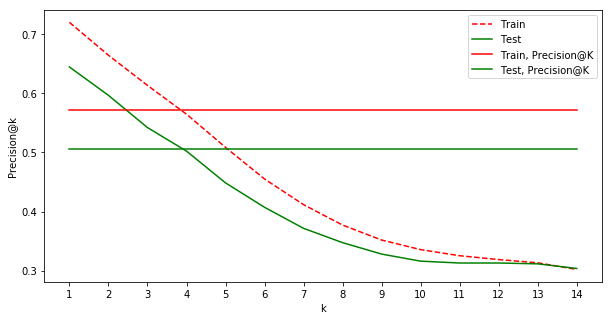

In [34]:
plt.figure(figsize=[10,5])
plt.plot(precisions_train, ls='--', c='r', label='Train')
plt.plot(precisions_test,  ls='-',  c='g', label='Test')
plt.plot([precisionK_train for k in range(nLabels)], ls='-', c='r', label='Train, Precision@K')
plt.plot([precisionK_test  for k in range(nLabels)], ls='-', c='g', label='Test, Precision@K')
plt.xticks(np.arange(nLabels), np.arange(1,nLabels+1))
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.legend(loc='best')